In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import sys
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, LeaveOneOut
from sklearn.feature_selection import SequentialFeatureSelector

from get_data import *

### Data load

In [2]:
ds, cols_model = get_data_model_v2()
ds_municipios, mun = get_data_municipios()
ds_zonas, zonas = get_data_zonas()

Database object created


c:\Users\ivan\Desktop\Coding\corunaRealEstateMarket\bd.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.connection)


Column n_banos has more than 20% of missing values.
Column n_plazas_garaje has more than 20% of missing values.


In [4]:
cols_model.remove('direccion_x')
cols_model.remove('direccion_y')
x = ds[cols_model].drop('precio', axis=1)
y = ds['precio']/ds['tamano']

In [5]:
aux = ds[['municipio', 'precio', 'tamano']].copy()
aux['precio_m2'] = aux['precio']/aux['tamano']
df_municipio = aux.groupby('municipio').agg({'precio_m2': 'mean', 'tamano':'count'}).sort_values('precio_m2', ascending=False).reset_index()
df_municipio = df_municipio.rename(columns={'tamano':'n_viviendas'})
df_municipio['precio_m2'] = df_municipio['precio_m2'].round(2)
df_municipio[df_municipio['n_viviendas']>=5]

,municipio,precio_m2,n_viviendas
1,oleiros,10.82,83
2,a coruña,9.99,559
3,culleredo,8.58,11
4,sada,8.49,25
5,cambre,7.23,10
6,arteixo,6.57,26
7,bergondo,6.18,8


### Model: Linear reg

In [79]:
def train_model(x,y, model, n_splits=5, n_repeats=5):
    return_val = []
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
    rkf.get_n_splits(x, y)
    for i, (train_index, val_index) in enumerate(rkf.split(x)):
        x_train = x.iloc[train_index]
        y_train = y.iloc[train_index]
        x_val = x.iloc[val_index]
        y_val = y.iloc[val_index]
        model.fit(x_train, y_train)
        y_train_pred = model.predict(x_train)
        y_val_pred = model.predict(x_val)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_val = mean_absolute_error(y_val, y_val_pred) 
        return_val.append({'rmse_train': rmse_train, 'rmse_val': rmse_val, 'mae_train': mae_train, 'mae_val': mae_val})
    return return_val

#### Linear reg

Repeated CV

In [42]:
trainings = train_model(x,y, LinearRegression(), n_splits=5, n_repeats=5)
rmse_train = [x['rmse_train'] for x in trainings]
rmse_val = [x['rmse_val'] for x in trainings]
mae_train = [x['mae_train'] for x in trainings]
mae_val = [x['mae_val'] for x in trainings]

print(f'RMSE train:\t mean {np.mean(rmse_train):.2f}\t std {np.std(rmse_train):.2f}')
print(f'RMSE val:\t mean {np.mean(rmse_val):.2f}\t std {np.std(rmse_val):.2f}')
print("")
print(f'MAE train:\t mean {np.mean(mae_train):.2f}\t std {np.std(mae_train):.2f}')
print(f'MAE val:\t mean {np.mean(mae_val):.2f}\t std {np.std(mae_val):.2f}')

RMSE train:	 mean 4.14	 std 0.39
RMSE val:	 mean 4.24	 std 1.28

MAE train:	 mean 2.33	 std 0.14
MAE val:	 mean 2.45	 std 0.23


LeaveOneOut

In [25]:
trainings = train_model(x,y, LinearRegression(), n_splits=len(x), n_repeats=1)
rmse_train = [x['rmse_train'] for x in trainings]
mae_train = [x['mae_train'] for x in trainings]
errors_val = [x['mae_val'] for x in trainings]
rmse_val = np.sqrt(np.power(errors_val, 2).mean())
mae_val = np.mean(errors_val)

print(f'RMSE train:\t mean {np.mean(rmse_train):.2f}\t std {np.std(rmse_train):.2f}')
print(f'RMSE val:\t mean {np.mean(rmse_val):.2f}\t std {np.std(errors_val):.2f}')
print("")
print(f'MAE train:\t mean {np.mean(mae_train):.2f}\t std {np.std(mae_train):.2f}')
print(f'MAE val:\t mean {np.mean(mae_val):.2f}\t std {np.std(errors_val):.2f}')

RMSE train:	 mean 4.19	 std 0.02
RMSE val:	 mean 4.37	 std 3.63

MAE train:	 mean 2.33	 std 0.01
MAE val:	 mean 2.43	 std 3.63


#### Variable selection

In [26]:
def get_step_score(current_cols, new_col, x, y, model):
    cols = current_cols + [new_col]
    trainings = train_model(x[cols],y, model)
    rmse_train = [x['rmse_train'] for x in trainings]
    rmse_train = np.mean(rmse_train)
    rmse_val = [x['rmse_val'] for x in trainings]
    rmse_val = np.mean(rmse_val)
    return rmse_train, rmse_val

current_cols = []
scores_train = []
scores_val = []
cols = []
all_columns = cols_model[:]
all_columns.remove('precio')

for k in range(len(all_columns)-1):
    best_col = None
    best_score_training = 1e20
    best_score_val = 1e20
    best_model = None
    for col in set(all_columns)-set(current_cols):
        score_training, score_val = get_step_score(current_cols, col, x, y, LinearRegression())
        if score_training < best_score_training:
            best_score_training = score_training
            best_score_val = score_val
            best_col = col
    current_cols.append(best_col)
    scores_train.append(best_score_training)
    scores_val.append(best_score_val)
    cols.append(current_cols[:])
    print(f'Best column: {best_col}\t score training:{best_score_training:.2f}\t score_val:{score_val:.2f}')

Best column: n_habitaciones	 score training:4.65	 score_val:4.77
Best column: playa	 score training:4.56	 score_val:4.50
Best column: es_casa	 score training:4.50	 score_val:4.43
Best column: tamano	 score training:4.44	 score_val:4.47
Best column: sin_ascensor	 score training:4.38	 score_val:4.41
Best column: densidad	 score training:4.33	 score_val:4.34
Best column: oleiros	 score training:4.29	 score_val:4.33
Best column: estudiantes	 score training:4.25	 score_val:4.25
Best column: balcon	 score training:4.23	 score_val:4.25
Best column: estrenar	 score training:4.22	 score_val:4.27
Best column: amueblado	 score training:4.21	 score_val:4.25
Best column: vacacional	 score training:4.19	 score_val:4.30
Best column: piscina	 score training:4.17	 score_val:4.24
Best column: vistas	 score training:4.18	 score_val:4.25
Best column: coruna	 score training:4.17	 score_val:4.25
Best column: valoracion	 score training:4.17	 score_val:4.24
Best column: parking	 score training:4.16	 score_val

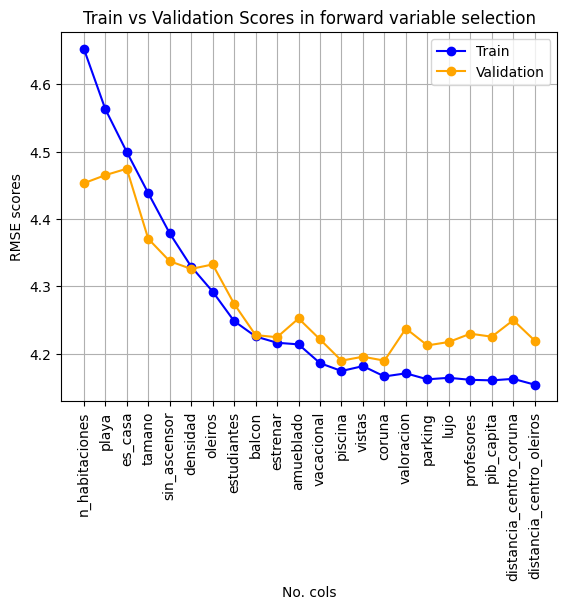

In [27]:
idx = list(range(len(current_cols)))
plt.plot(idx, scores_train, marker='o', linestyle='-', color='blue', label='Train')
plt.plot(idx, scores_val, marker='o', linestyle='-', color='orange', label='Validation')

plt.xlabel('No. cols')
plt.ylabel('RMSE scores')
plt.title('Train vs Validation Scores in forward variable selection')
plt.xticks(idx, current_cols)  # Use column names as x-axis labels
#in vertical
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()

### Model: KNN

In [28]:
x_dir = ds[['direccion_x', 'direccion_y', 'tamano', 'precio', 'n_habitaciones']].copy()
x_dir['precio_m2'] = x_dir['precio']/x_dir['tamano']
x_dir = x_dir.dropna().reset_index(drop=True)
y_dir = x_dir['precio_m2']
x_dir = x_dir.drop(['precio', 'precio_m2'], axis=1)

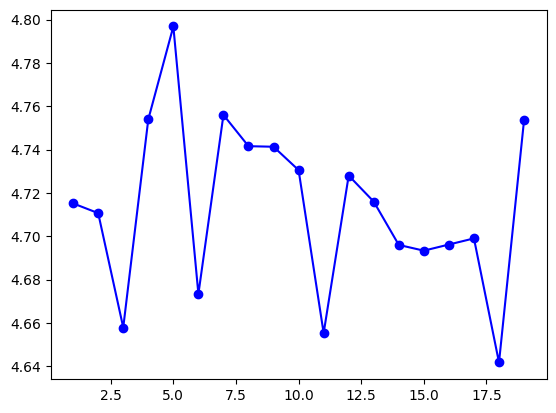

In [29]:
from sklearn.neighbors import KNeighborsRegressor

scores = []
for k in range(1,20):
    knn = KNeighborsRegressor(n_neighbors=5)
    trainings = train_model(x_dir,y_dir, knn, n_splits=5, n_repeats=5)
    rmse_train = [x['rmse_train'] for x in trainings]
    rmse_val = [x['rmse_val'] for x in trainings]
    mae_train = [x['mae_train'] for x in trainings]
    mae_val = [x['mae_val'] for x in trainings]

    # print(f'RMSE train:\t mean {np.mean(rmse_train):.2f}\t std {np.std(rmse_train):.2f}')
    # print(f'RMSE val:\t mean {np.mean(rmse_val):.2f}\t std {np.std(rmse_val):.2f}')
    # print("")
    # print(f'MAE train:\t mean {np.mean(mae_train):.2f}\t std {np.std(mae_train):.2f}')
    # print(f'MAE val:\t mean {np.mean(mae_val):.2f}\t std {np.std(mae_val):.2f}')
    scores.append(np.mean(rmse_val))

plt.plot(range(1, 20), scores, marker='o', linestyle='-', color='blue', label='Train')

### Geospatial

In [9]:
data = ds[['precio', 'direccion_x', 'direccion_y', "tamano", "n_habitaciones"]]
data = data[data['direccion_x']<43.40]
data = data[data['direccion_x']>43.30]
# data = data[data['direccion_y']<-8.35]
# data = data[data['direccion_y']>-8.45]

data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 680 entries, 0 to 712
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   precio          680 non-null    float64
 1   direccion_x     680 non-null    float64
 2   direccion_y     680 non-null    float64
 3   tamano          680 non-null    float64
 4   n_habitaciones  680 non-null    float64
dtypes: float64(5)
memory usage: 31.9 KB


In [3]:
ds['precio_m2'] = ds['precio']/ds['tamano']

In [10]:
viv_zonas = ds.groupby('zona_v2').agg({'titulo':'count','precio':'mean', 'precio_m2':'mean', 'tamano':'mean', 'n_habitaciones':'mean'}).reset_index()
viv_zonas = viv_zonas.rename(columns={'titulo':'n_viviendas'})
viv_zonas = viv_zonas.sort_values(['n_habitaciones', 'tamano'], ascending=False)
plano = viv_zonas[['n_habitaciones', 'tamano']].copy()
viv_zonas

,zona_v2,n_viviendas,precio,precio_m2,tamano,n_habitaciones
3,bergondo,8,1116.875000,6.175132,186.375000,4.000000
17,paseo de los puentes-santa margarita,6,763.333333,7.998511,95.833333,3.333333
12,maianca,11,1607.727273,17.923288,135.454545,3.000000
0,abegondo,1,2000.000000,18.181818,110.000000,3.000000
5,carral,1,450.000000,4.500000,100.000000,3.000000
4,cambre,10,938.000000,7.229554,134.800000,2.900000
1,agra del orzan - ventorrillo,44,744.318182,8.915367,86.795455,2.886364
18,perillo,31,1343.709677,11.832662,116.838710,2.870968
16,os mallos,47,742.765957,8.785018,87.042553,2.851064
15,nos,33,1092.424242,8.316783,129.242424,2.818182


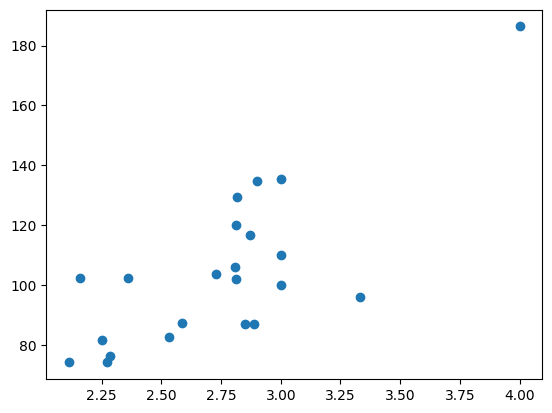

In [11]:
plt.scatter(plano['n_habitaciones'], plano['tamano'])

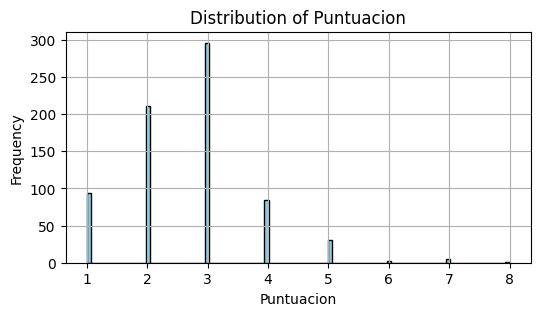

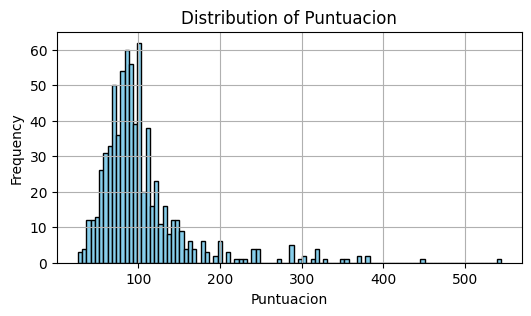

In [10]:
plt.figure(figsize=(6, 3))
plt.hist(ds['n_habitaciones'], bins=100, color='skyblue', edgecolor='black')  # Adjust bins as needed
plt.title('Distribution of Puntuacion')
plt.xlabel('Puntuacion')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 3))
plt.hist(ds['tamano'], bins=100, color='skyblue', edgecolor='black')  # Adjust bins as needed
plt.title('Distribution of Puntuacion')
plt.xlabel('Puntuacion')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [19]:
def normalize_str(x):
    if x is not None:
        x = x.lower()
        x = x.replace('á', 'a')
        x = x.replace('é', 'e')
        x = x.replace('í', 'i')
        x = x.replace('ó', 'o')
        x = x.replace('ú', 'u')
    return x

co_1 = ['Monte Alto - Zalaeta - Atocha']
co_2 = ['Ciudad Vieja - Centro']
co_3 = ['Ensanche - Juan Florez']
co_4 = ['Riazor - Los Rosales']
co_5 = ['Agra del Orzán - Ventorrillo', 'Vioño']
co_6 = ['Os Mallos', 'Sagrada Familia']
co_7 = ['Cuatro Caminos - Plaza de la Cubela']
co_8 = ['Falperra-Santa Lucía']
co_9 = ['Paseo de los Puentes-Santa Margarita']
co_10 = ['Someso - Matogrande', 'Eirís']
co_11 = ['Mesoiro']
co_12 = ['Los Castros - Castrillón']
co = [co_1, co_2, co_3, co_4, co_5, co_6, co_7, co_8, co_9, co_10, co_11, co_12]

ol_1 = ['Nós', 'Dexo-Lorbé', 'Dorneda', 'Mera-Serantes', 'Liáns', 'Iñás']
ol_2 = ['Mainca']
ol_3 = ['Perillo']
ol = [ol_1, ol_2, ol_3]

zonas_seleccionadas = {'a coruña': co, 'oleiros': ol}

normalized_zonas = {}

for key, sublist in zonas_seleccionadas.items():
    print(key, sublist)
    normalized_sublist = []
    for subsublist in sublist:
        normalized_items = [normalize_str(item) for item in subsublist]
        normalized_sublist.append(normalized_items)
    normalized_zonas[key] = normalized_sublist

print(normalized_zonas)


a coruña [['Monte Alto - Zalaeta - Atocha'], ['Ciudad Vieja - Centro'], ['Ensanche - Juan Florez'], ['Riazor - Los Rosales'], ['Agra del Orzán - Ventorrillo', 'Vioño'], ['Os Mallos', 'Sagrada Familia'], ['Cuatro Caminos - Plaza de la Cubela'], ['Falperra-Santa Lucía'], ['Paseo de los Puentes-Santa Margarita'], ['Someso - Matogrande', 'Eirís'], ['Mesoiro'], ['Los Castros - Castrillón']]
oleiros [['Nós', 'Dexo-Lorbé', 'Dorneda', 'Mera-Serantes', 'Liáns', 'Iñás'], ['Mainca'], ['Perillo']]
{'a coruña': [['monte alto - zalaeta - atocha'], ['ciudad vieja - centro'], ['ensanche - juan florez'], ['riazor - los rosales'], ['agra del orzan - ventorrillo', 'vioño'], ['os mallos', 'sagrada familia'], ['cuatro caminos - plaza de la cubela'], ['falperra-santa lucia'], ['paseo de los puentes-santa margarita'], ['someso - matogrande', 'eiris'], ['mesoiro'], ['los castros - castrillon']], 'oleiros': [['nos', 'dexo-lorbe', 'dorneda', 'mera-serantes', 'lians', 'iñas'], ['mainca'], ['perillo']]}


C:\Users\ivan\AppData\Local\Temp\ipykernel_3776\3114051616.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('RdYlGn_r')


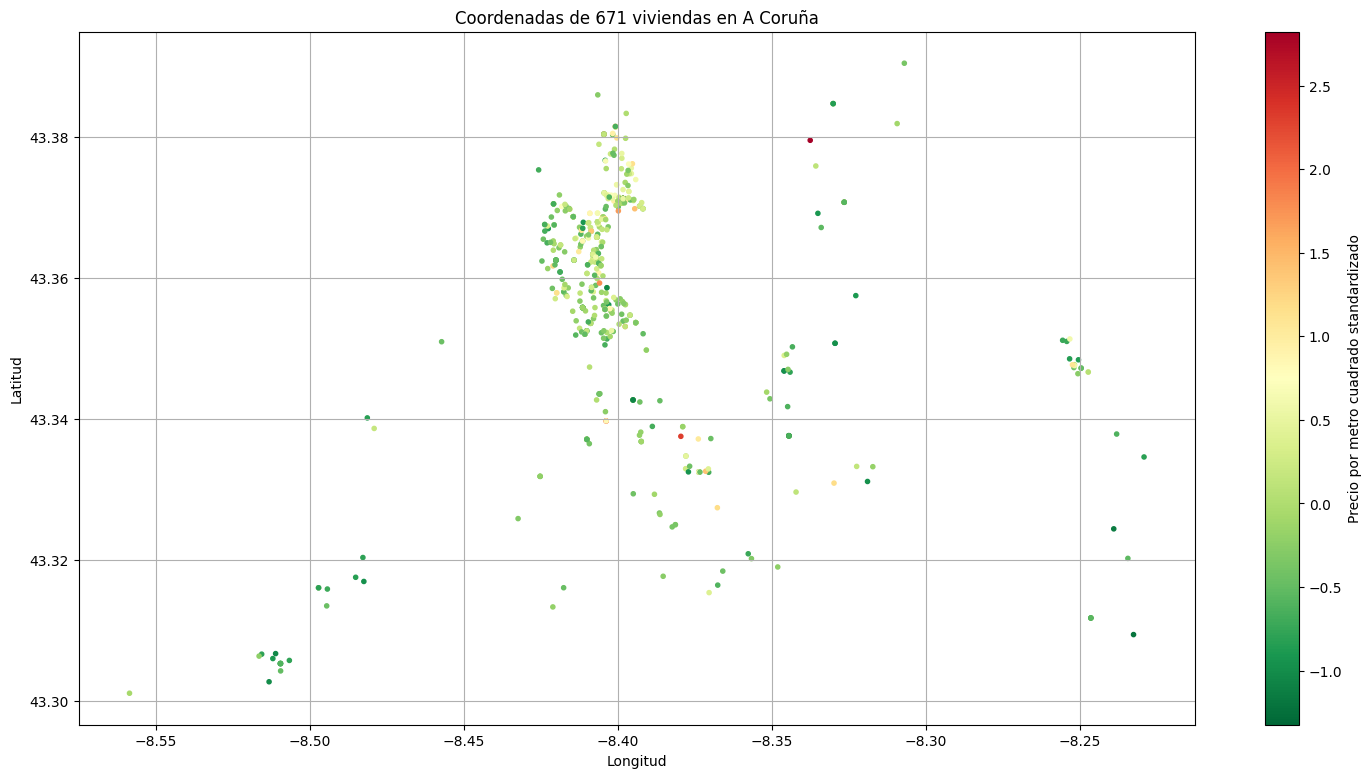

In [10]:
filter = 3
filter_left = -3

longs = np.array(data['direccion_x'].values.tolist())
lats = np.array(data['direccion_y'].values.tolist())
precio_m2 = np.array((data['precio']/data['tamano']).values.tolist())
normalized_precios = (precio_m2 - np.mean(precio_m2)) / np.std(precio_m2)

lats = lats[(np.abs(normalized_precios)<filter) & (normalized_precios>filter_left)]
longs = longs[(np.abs(normalized_precios)<filter) & (normalized_precios>filter_left)]
normalized_precios = normalized_precios[(np.abs(normalized_precios)<filter) & (normalized_precios>filter_left)]

# Define a colormap ranging from green to red
colormap = plt.cm.get_cmap('RdYlGn_r')

# Create the scatter plot
plt.figure(figsize=(18, 9))
scatter = plt.scatter(lats, longs, c=normalized_precios, cmap=colormap, marker='.')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Coordenadas de ' + str(len(lats)) + ' viviendas en A Coruña')
plt.grid(True)

# Add colorbar to indicate price range
cbar = plt.colorbar(scatter)
cbar.set_label('Precio por metro cuadrado standardizado')

plt.show()